In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sys
import os 
import re
import string
from math import*
#import jellyfish
import gensim
from gensim.models import *
#from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('universal_tagset')

#from shared_lib import utils, vocabulary

#import xgboost as xgb
#from tqdm import tqdm
#import spacy

import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB 
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import f1_score
from sklearn.grid_search import GridSearchCV

from textblob import TextBlob
#reload(utils)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harinath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/harinath/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.


In [3]:
df_train=pd.read_csv('/Users/harinath/downloads/train.csv', sep=',',header=0).fillna("")
df_test=pd.read_csv('/Users/harinath/downloads/test.csv', sep=',',header=0).fillna("")

In [9]:
print ("Total Number of positive cases in training data: ", sum(df_train['is_duplicate'] == 1))
print ("Total Number of negative cases in training data: ", sum(df_train['is_duplicate'] == 0))
print ("Percentage Positive cases: {:.2f} %".format((sum(df_train['is_duplicate'] == 1))*100.0/df_train.shape[0]))
print ("Percentage Negative cases: {:.2f} %".format((sum(df_train['is_duplicate'] == 0))*100.0/df_train.shape[0]))

Total Number of positive cases in training data:  149263
Total Number of negative cases in training data:  255027
Percentage Positive cases: 36.92 %
Percentage Negative cases: 63.08 %


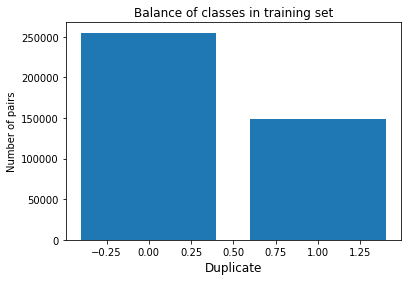

In [11]:
count_duplicate = df_train['is_duplicate'].value_counts()
plt.bar([0, 1], count_duplicate.values)
plt.ylabel('Number of pairs')
plt.xlabel('Duplicate', fontsize=12)
plt.title('Balance of classes in training set')
plt.show()

Total number of questions in the training data: 537933


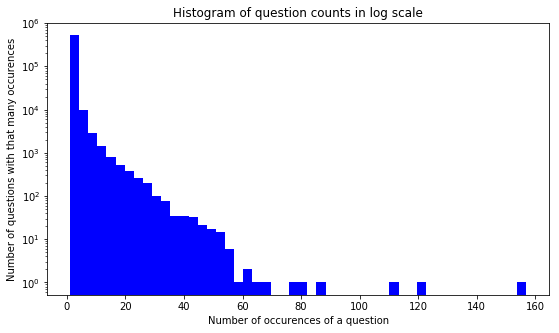

In [10]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
print('Total number of questions in the training data: {}'.format(len(np.unique(qids))))

plt.figure(figsize=(9, 5))
plt.hist(qids.value_counts(), bins=50, color='blue')
plt.yscale('log', nonposy='clip')
plt.title('Histogram of question counts in log scale')
plt.xlabel('Number of occurences of a question')
plt.ylabel('Number of questions with that many occurences')
plt.show()

In [4]:
import math

def cleanse_data(doc):
    tokenizer = RegexpTokenizer(r'\w+')
    #raw = re.sub('\d+',"num", s)
    if type(doc) is str:
        if doc == '':
            raw = 'empty string'
        else:
            raw = doc.lower()
    elif math.isnan(doc):
        raw = "empty string"
    elif isinstance(doc, float):
        new_doc = "empty string"
    tokens = word_tokenize(raw)
    return tokens

# Find the shared words
def shared_words_func(a,b):
    q1_shared = [w for w in a if w in b]
    q2_shared = [w for w in b if w in a]
    R = (len(q1_shared) + len(q2_shared))/float(len(a) + len(b))
    return R

### Compute length of questions
def quest_length(q1, q2):
    q1_length = [len(i) for i in q1]
    q2_length = [len(str(i)) for i in q2]
    q1_numwords = [len(i.split(" ")) for i in q1]
    q2_numwords = [len(str(i).split(" ")) for i in q2]
    return q1_length, q2_length, q1_numwords, q2_numwords

# Computer cosine distance
def ochiai_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    sqrt_product = math.sqrt(len(x)) * math.sqrt(len(y))
    return intersection_cardinality/float(sqrt_product)

# Compute Jaccard Similarity Score 
def jaccard_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

## Compute other similarity measures
def overlap_similarity(x, y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    min_set = min(len(set(x)), len(set(y)))
    return intersection_cardinality/float(min_set)

# Computer Similarity for the whole data set based on score function
def similarity_scores(func, q1, q2):
    similarity_scores = []
    for i in range(len(q1)):
        try:
            similarity_scores.append(func(q1[i], q2[i]))
        except:
            print (i, q1[i], q2[i])
    return similarity_scores

# Other Potential Features
# Similarity Measures
def similarity_measures(ques1, ques2):
    damerau_levenshtein_scores = []
    jaro_winkler_scores = []
    hamming_distance_scores = []

    for qs in range(len(ques1)):
        try:
            q1c = re.sub('[^A-Za-z0-9 \\n]+', "", ques1[qs])
            q2c = re.sub('[^A-Za-z0-9 \\n]+', "", ques2[qs])
            q1 = unicode(q1c, "utf-8")
            q2 = unicode(q2c, "utf-8")
            damerau_levenshtein_scores.append(jellyfish.damerau_levenshtein_distance(q1,q2))
            jaro_winkler_scores.append(jellyfish.jaro_winkler(q1,q2))
            hamming_distance_scores.append(jellyfish.hamming_distance(q1,q2))
        #    print "1"

        except:
            #print question1[qs], question2[qs]
        #    print "2"
            q1c = re.sub('[^A-Za-z0-9 \\n]+', "", ques1[qs])
            q1 = unicode(q1c, "utf-8")
            empty_str = unicode("empty string", "utf-8")
            damerau_levenshtein_scores.append(jellyfish.damerau_levenshtein_distance(q1,empty_str))
            jaro_winkler_scores.append(jellyfish.jaro_winkler(q1,empty_str))
            hamming_distance_scores.append(jellyfish.hamming_distance(q1, empty_str))
    return damerau_levenshtein_scores, jaro_winkler_scores, hamming_distance_scores

# Compute number of nouns and sentiment of sentences using TextBlob
def noun_sentiment(x,y):
    noun_diff = []
    pol_diff = []
    sub_diff = []
    for i in range(len(x)):
        sent1 = TextBlob(unicode(x[i], "utf-8"))
        sent2 = TextBlob(unicode(y[i], "utf-8"))
        try:
            num_nouns1  = len(sent1.noun_phrases)
            num_nouns2  = len(sent2.noun_phrases)   
            diff_nouns = abs(num_nouns1 - num_nouns2)
            if (num_nouns1 + num_nouns2) == 0:
                norm_diff_nouns = 0
            else:
                norm_diff_nouns = diff_nouns/float(num_nouns1 + num_nouns2)
            polarity_score1  = sent1.sentiment.polarity
            polarity_score2  = sent2.sentiment.polarity
            subjectivity_score1  = sent1.sentiment.subjectivity
            subjectivity_score2  = sent2.sentiment.subjectivity
            polarity_diff = abs(polarity_score1 - polarity_score2)
            subjectivity_diff = abs(subjectivity_score1 - subjectivity_score2)
            noun_diff.append(norm_diff_nouns)
            pol_diff.append(polarity_diff)
            sub_diff.append(subjectivity_diff)
        except:
            print (sent1, sent2)
    return noun_diff, pol_diff, sub_diff
    
# Calculate the number of Unique words
def unique_words(x, y):
    unique_word_list = []
    unique_word_cnt = []
    unique_word_pos = []
    for i in range(len(x)):
        intersection_set = set.intersection(*[set(x[i]), set(y[i])])
        union_set = set.union(*[set(x[i]), set(y[i])])
        unique_words = union_set - intersection_set
        unique_word_list.append(unique_words)
        unique_word_cnt.append(len(unique_words))                
    return unique_word_list, unique_word_cnt

In [5]:
def calculate_similarity_score_vectors(df, test = 'N'):
    #print df
    if test == 'N':
        id_vals = df['id'].values
        qid1_vals = df['qid1'].values
        qid2_vals = df['qid2'].values
        duplicate = df['is_duplicate'].values
    else:
        id_vals = df['test_id'].values
        duplicate = []
    question1 = df['question1'].values
    question2 = df['question2'].values
    q1_tokens = [cleanse_data(q) for q in question1]
    q2_tokens = [cleanse_data(q) for q in question2]
    print("Total Number of Questions Pairs: ", len(q1_tokens), len(q2_tokens))
    
    # Calculate features
    ochiai = similarity_scores(ochiai_similarity, q1_tokens, q2_tokens)
    jaccard = similarity_scores(jaccard_similarity, q1_tokens, q2_tokens)
    overlap = similarity_scores(overlap_similarity, q1_tokens, q2_tokens)
    
    # Shared words normalized
    shared_words_norm = []
    for z in range(len(q1_tokens)):
        try:
            shared_words_norm.append(shared_words_func(q1_tokens[z], q2_tokens[z]))
        except:
            shared_words_norm.append(0.0)
    
    return id_vals, question1, question2, duplicate, ochiai, jaccard, overlap, shared_words_norm

In [6]:
df_train_clean = pd.read_csv('/Users/harinath/downloads/train.csv').fillna("")

if os.path.exists('train_feature_df.pkl'):
    feature_df = pd.read_pickle('train_feature_df.pkl')
else: # For traiing
    id_vals, question1, question2, duplicate, ochiai, jaccard, overlap, shared_words_norm = calculate_similarity_score_vectors(df_train_clean)   
    q1_length, q2_length, q1_numwords, q2_numwords = quest_length(question1, question2)
    ## Build a pandas dataframe off the computed features
    feature_df = pd.DataFrame(
        {'id' : id_vals,
         'q1_length': q1_length,
         'question1': question1,
         'q2_length': q2_length,
         'question2' : question2,
         'q1_numwords': q1_numwords,
         'q2_numwords': q2_numwords,
         'ochiai': ochiai,
         'jaccard': jaccard,
         'overlap': overlap,
         'shared_words_norm' : shared_words_norm
        })
    print("Feature vector shape: ", feature_df.shape)
    ## Save the train dataframe to pickle to save space
    pd.to_pickle(feature_df, 'train_feature_df.pkl')

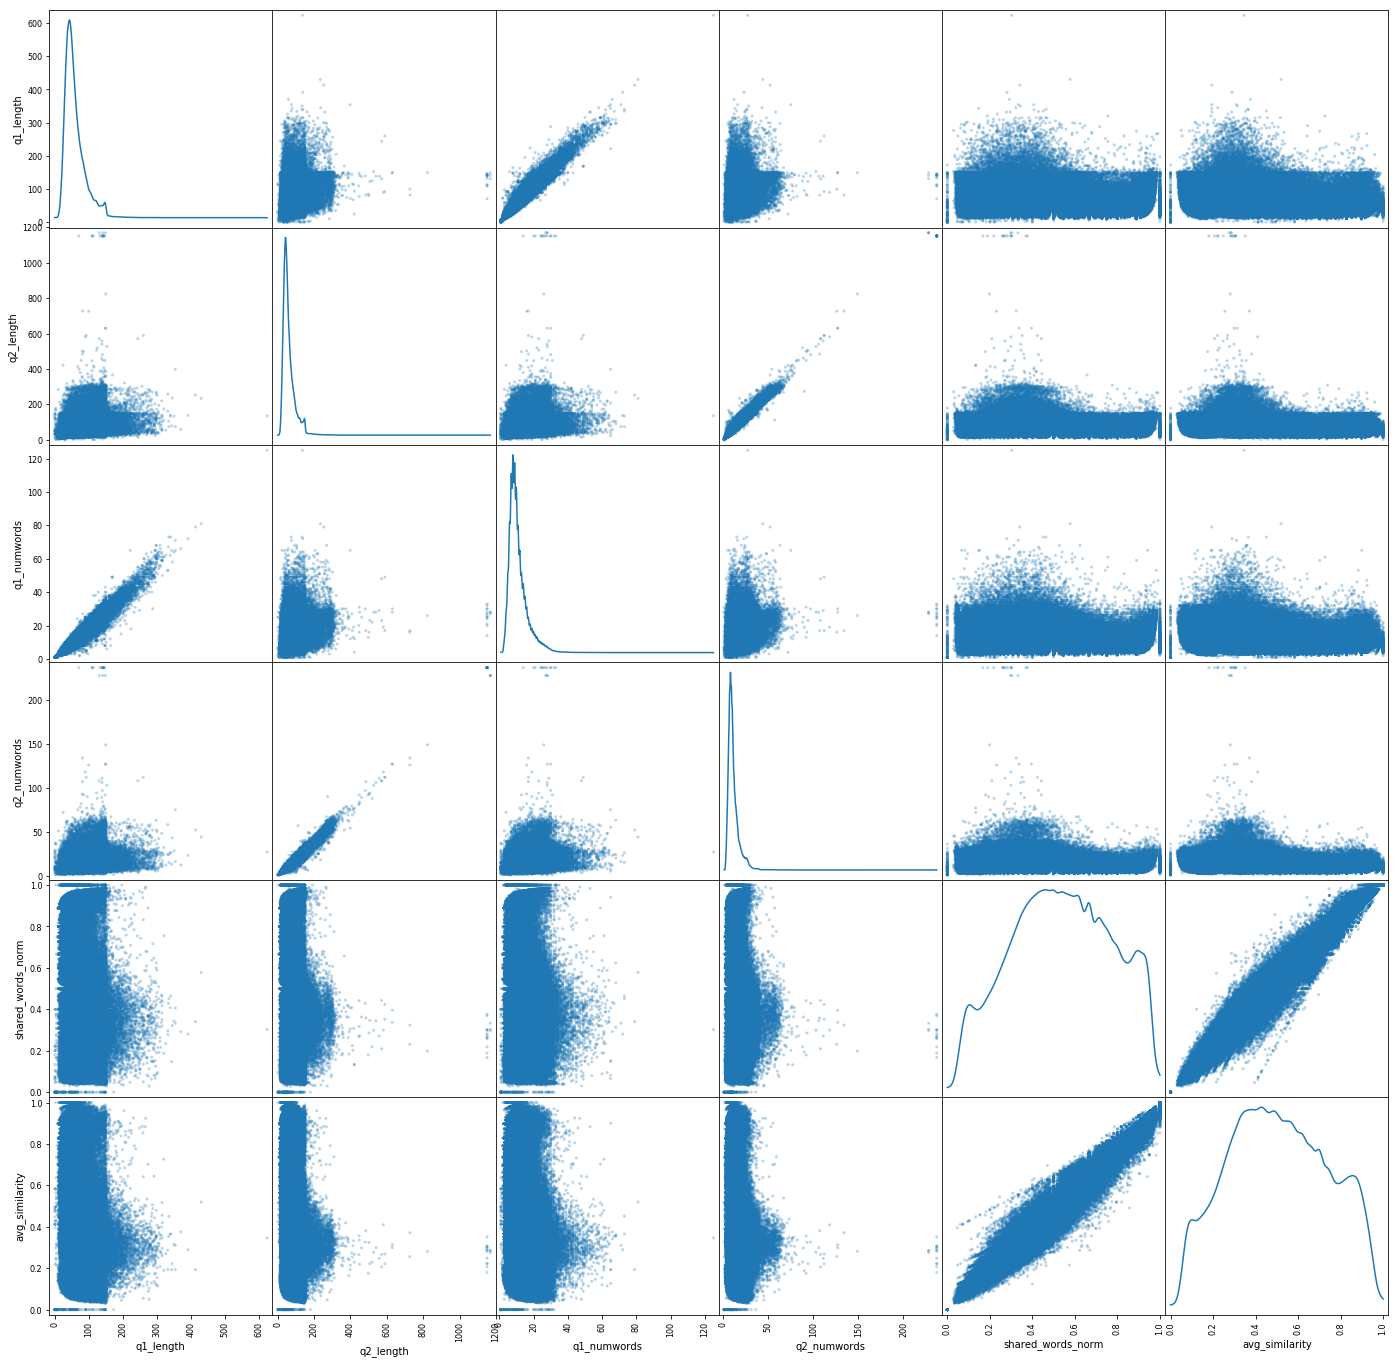

In [7]:
feature_df['avg_similarity'] = (feature_df['jaccard'] + feature_df['overlap'] + feature_df['ochiai']) / 3.0
feature_df.drop(['jaccard', 'overlap', 'ochiai'], axis=1, inplace = True)
pd.plotting.scatter_matrix(feature_df[['q1_length', 'q2_length', 'q1_numwords', 'q2_numwords', \
            'shared_words_norm', 'avg_similarity']], alpha = 0.3, figsize = (24,24), diagonal = 'kde');

In [31]:
print(feature_df.columns)

Index(['id', 'q1_length', 'q1_numwords', 'q2_length', 'q2_numwords',
       'question1', 'question2', 'shared_words_norm', 'avg_similarity'],
      dtype='object')


In [ ]:
import time
import pandas as pd
from ggplot import *
import seaborn as sns

from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
clustering_df=feature_df[feature_df.columns.difference(['question1', 'question2','id'])]
tsne_results = tsne.fit_transform(clustering_df.values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 404290 samples in 0.917s...
[t-SNE] Computed neighbors for 404290 samples in 35.072s...
[t-SNE] Computed conditional probabilities for sample 1000 / 404290
[t-SNE] Computed conditional probabilities for sample 2000 / 404290
[t-SNE] Computed conditional probabilities for sample 3000 / 404290
[t-SNE] Computed conditional probabilities for sample 4000 / 404290
[t-SNE] Computed conditional probabilities for sample 5000 / 404290
[t-SNE] Computed conditional probabilities for sample 6000 / 404290
[t-SNE] Computed conditional probabilities for sample 7000 / 404290
[t-SNE] Computed conditional probabilities for sample 8000 / 404290
[t-SNE] Computed conditional probabilities for sample 9000 / 404290
[t-SNE] Computed conditional probabilities for sample 10000 / 404290
[t-SNE] Computed conditional probabilities for sample 11000 / 404290
[t-SNE] Computed conditional probabilities for sample 12000 / 404290
[t-SNE] Computed conditional proba

[t-SNE] Computed conditional probabilities for sample 122000 / 404290
[t-SNE] Computed conditional probabilities for sample 123000 / 404290
[t-SNE] Computed conditional probabilities for sample 124000 / 404290
[t-SNE] Computed conditional probabilities for sample 125000 / 404290
[t-SNE] Computed conditional probabilities for sample 126000 / 404290
[t-SNE] Computed conditional probabilities for sample 127000 / 404290
[t-SNE] Computed conditional probabilities for sample 128000 / 404290
[t-SNE] Computed conditional probabilities for sample 129000 / 404290
[t-SNE] Computed conditional probabilities for sample 130000 / 404290
[t-SNE] Computed conditional probabilities for sample 131000 / 404290
[t-SNE] Computed conditional probabilities for sample 132000 / 404290
[t-SNE] Computed conditional probabilities for sample 133000 / 404290
[t-SNE] Computed conditional probabilities for sample 134000 / 404290
[t-SNE] Computed conditional probabilities for sample 135000 / 404290
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 248000 / 404290
[t-SNE] Computed conditional probabilities for sample 249000 / 404290
[t-SNE] Computed conditional probabilities for sample 250000 / 404290
[t-SNE] Computed conditional probabilities for sample 251000 / 404290
[t-SNE] Computed conditional probabilities for sample 252000 / 404290
[t-SNE] Computed conditional probabilities for sample 253000 / 404290
[t-SNE] Computed conditional probabilities for sample 254000 / 404290
[t-SNE] Computed conditional probabilities for sample 255000 / 404290
[t-SNE] Computed conditional probabilities for sample 256000 / 404290
[t-SNE] Computed conditional probabilities for sample 257000 / 404290
[t-SNE] Computed conditional probabilities for sample 258000 / 404290
[t-SNE] Computed conditional probabilities for sample 259000 / 404290
[t-SNE] Computed conditional probabilities for sample 260000 / 404290
[t-SNE] Computed conditional probabilities for sample 261000 / 404290
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 370000 / 404290
[t-SNE] Computed conditional probabilities for sample 371000 / 404290
[t-SNE] Computed conditional probabilities for sample 372000 / 404290
[t-SNE] Computed conditional probabilities for sample 373000 / 404290
[t-SNE] Computed conditional probabilities for sample 374000 / 404290
[t-SNE] Computed conditional probabilities for sample 375000 / 404290
[t-SNE] Computed conditional probabilities for sample 376000 / 404290
[t-SNE] Computed conditional probabilities for sample 377000 / 404290
[t-SNE] Computed conditional probabilities for sample 378000 / 404290
[t-SNE] Computed conditional probabilities for sample 379000 / 404290
[t-SNE] Computed conditional probabilities for sample 380000 / 404290
[t-SNE] Computed conditional probabilities for sample 381000 / 404290
[t-SNE] Computed conditional probabilities for sample 382000 / 404290
[t-SNE] Computed conditional probabilities for sample 383000 / 404290
[t-SNE] Computed con

In [ ]:
df_tsne=df_train_clean[df_train_clean.columns.difference(['qid1', 'qid2', 'question1', 'question2'])].copy()
df_tsne['x_tsne'] = tsne_results[:,0]
df_tsne['y_tsne'] = tsne_results[:,1]

In [ ]:
setosa = df_tsne.loc[df_tsne.is_ == "Admit"]
virginica = df_tsne.loc[df_tsne.disposition == "Discharge"]
ax = sns.kdeplot(setosa.x_tsne, setosa.y_tsne,
                  cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.x_tsne, virginica.y_tsne,
                 cmap="Blues", shade=True, shade_lowest=False)